<a href="https://colab.research.google.com/github/mehdi-or/MachinLearning-DeepLearning/blob/main/BioInfoAll2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install py3Dmol
!pip install biopython
!pip install lazypredict
!pip install chembl_webresource_client
import py3Dmol
from Bio.PDB import *
# all of the above are for visualization of target protein
from google.colab import drive
drive.mount('/content/gdrive', force_remount=False)
import pandas as pd
import numpy as np
from chembl_webresource_client.new_client import new_client
import seaborn as sns
sns.set(style='ticks')
import matplotlib.pyplot as plt

#Data collectioin in ChEMBL
1. choosing protein of interest
2. collecting its bioactivity data related to IC50

selecting human Acetylcholinesterase. To do this we need to know the name of chembl id of human Acetylcholinesterase which is 'CHEMBL220'

In [2]:
target = new_client.target
target_proteins = pd.DataFrame.from_dict(target.search('acetylcholinesterase')) # to search for the protein and converting it to dataframe
target_shape = target_proteins.shape
# choosing a single protein in homoseipiens:
selected_target = target_proteins.target_chembl_id[0]
print( 'The selectred single protein in homoseipiens is: ' + selected_target)
target_proteins.head(n=3)

The selectred single protein in homoseipiens is: CHEMBL220


,cross_references,organism,pref_name,score,species_group_flag,target_chembl_id,target_components,target_type,tax_id
0,"[{'xref_id': 'P22303', 'xref_name': None, 'xre...",Homo sapiens,Acetylcholinesterase,27.0,False,CHEMBL220,"[{'accession': 'P22303', 'component_descriptio...",SINGLE PROTEIN,9606
1,[],Homo sapiens,Cholinesterases; ACHE & BCHE,27.0,False,CHEMBL2095233,"[{'accession': 'P06276', 'component_descriptio...",SELECTIVITY GROUP,9606
2,[],Drosophila melanogaster,Acetylcholinesterase,18.0,False,CHEMBL2242744,"[{'accession': 'P07140', 'component_descriptio...",SINGLE PROTEIN,7227


To download the pdb file of the homoseipiens acytocholinestrase

In [ ]:
 ##doanloading the desired protein's pdb file. here we are downloading acytocholinestrase
!wget http://www.rcsb.org/pdb/files/1eea.pdb
#!gunzip 1eea.pdb.gz # to unzip the ziped file
#To know the number of chains and residues of the preotein
!grep 'COMPND'.*'CHAIN' 1eea.pdb #pdb file for acytocholinestrase
print('the number of residuals are: ')
!awk '$1=="ATOM" && $3=="CA" && $5=="A" {print $0}' 1eea.pdb | wc -l

In [4]:
#To set up a parser for our PDB
parser = PDBParser()
io=PDBIO()
structure = parser.get_structure('X', '1eea.pdb')

#This will separate each chain into its own PDB file
for chain in structure.get_chains():
    io.set_structure(chain)
    io.save("1eea_" + chain.get_id() + ".pdb")

To Visualize the protein

In [5]:
view=py3Dmol.view()
#to read the PDB files of chain B and C
view.addModel(open('1eea.pdb', 'r').read(),'pdb')
view.zoomTo()
view.setBackgroundColor('white')
view.setStyle({'chain':'A'},{'cartoon': {'color':'spectrum'}}) #same as : view.setStyle({'model':-1},{'cartoon': {'color':'spectrum'}})
view.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Tto get the bioactivity data related to Inhibition Concentration at 50% of *human Acetylcholinesterase - i.e. CHEMBL220*

In [6]:
activity = new_client.activity
res = activity.filter(target_chembl_id=selected_target).filter(standard_type="IC50")
# df_raw = pd.DataFrame.from_dict(res)
# dir = '/content/gdrive/MyDrive/Colab Notebooks/Tutorial/Bioinformatics/data/'
# df_raw.to_csv(dir + 'acetylcholinesterase_bioactivity_raw.csv', index=False)

#Data Preprocessing
1. removing the data point with missed values
2. removing the duplicate data based on the SMILE descriptors


The raw dataframe of IC50 bioactivitiy data from human acytocholine-strase

In [7]:
dir = '/content/gdrive/MyDrive/Colab Notebooks/Tutorial/Bioinformatics/data/'
df_raw = pd.read_csv(dir+ 'acetylcholinesterase_bioactivity_raw.csv')
print('the dimension of the raw IC50 raw data from human acytocholine_strase is: ' + str(df_raw.shape))
df_raw.head(n=3)

the dimension of the raw IC50 raw data from human acytocholine_strase is: (8832, 46)


,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,NaN,NaN,33969,[],CHEMBL643384,Inhibitory concentration against acetylcholine...,B,NaN,NaN,BAO_0000190,...,Homo sapiens,Acetylcholinesterase,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,0.75
1,NaN,NaN,37563,[],CHEMBL643384,Inhibitory concentration against acetylcholine...,B,NaN,NaN,BAO_0000190,...,Homo sapiens,Acetylcholinesterase,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,0.10
2,NaN,NaN,37565,[],CHEMBL643384,Inhibitory concentration against acetylcholine...,B,NaN,NaN,BAO_0000190,...,Homo sapiens,Acetylcholinesterase,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,50.00


In [8]:
#removing all the data point with NaN values in sratndar_value and canonical_smiles columns
df_droped = df_raw.dropna(subset=['standard_value', 'canonical_smiles'])
# now we drop douplicate values in canonical_smiles columns
df2_nr = df_droped.drop_duplicates(['canonical_smiles'])
#Picking the four columns of interest
#'molecule_chembl_id','canonical_smiles','standard_value', 'type'
selection = ['molecule_chembl_id','canonical_smiles','standard_value', 'type']
df_selected = df2_nr[selection]
df_selected.to_csv(dir+'acetylcholinesterase_02_bioactivity_preprocessed.csv', index=False)
df_selected.head(n=3)

,molecule_chembl_id,canonical_smiles,standard_value,type
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,750.0,IC50
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,100.0,IC50
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,50000.0,IC50


In [9]:
df_selected = pd.read_csv(dir+'acetylcholinesterase_02_bioactivity_preprocessed.csv')
# labeling the data based on bioactivity of IC50 (standard value) with unit concentration of nM
bioactivity_threshold = []
for ic50 in df_selected.standard_value:
  if float(ic50) >= 10000:
    bioactivity_threshold.append("inactive")
  elif float(ic50) >= 100 and float(ic50) <= 1000:
    bioactivity_threshold.append("active")
  elif float(ic50) <= 100:
    bioactivity_threshold.append("very_active")
  else:
    bioactivity_threshold.append("intermediate")

# combining all data together
bioactivity_class = pd.Series(bioactivity_threshold, name='activity_class')
df_curated = pd.concat([df_selected, bioactivity_class], axis=1)
IC50_droped_id = df_curated[df_curated.standard_value==0].index
df_curated = df_curated.drop(IC50_droped_id) # to drop those IC50 values that have a value of "0" resulting in infinity value of pIC50 and getting errors
df_curated.to_csv(dir+'acetylcholinesterase_03_bioactivity_curated.csv', index=False)

##codes before this do not to be ran since we have the curated data saved in google drive

In [10]:
dir = '/content/gdrive/MyDrive/Colab Notebooks/Tutorial/Bioinformatics/data/'
df_curated = pd.read_csv(dir+'acetylcholinesterase_03_bioactivity_curated.csv')
df_curated.head(n=3)

,molecule_chembl_id,canonical_smiles,standard_value,type,activity_class
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,750.0,IC50,active
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,100.0,IC50,active
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,50000.0,IC50,inactive


installing rdkit

In [11]:
!pip install rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 24.8 MB/s eta 0:00:00


In [12]:
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
IPythonConsole.ipython_useSVG=True  #< set this to False if you want PNGs instead of SVGs

#### **Note:**
In SMILES notations, the "." (period or "dot") serves as a symbol for disconnections. In the context of illustrating the valence model, the dot signifies a bond with a formal order of zero. This means that the atoms situated on either side of the "dot" are intentionally shown as unconnected to each other. In practical application, it is possible to write distinct structures separated by a dot, and the sequence in which ions or ligands are listed is not fixed. There is no inherent implication of matching one charge with another, and it is not mandatory for the overall charge to be zero.

In [13]:
df_no_smiles = df_curated.drop(columns='canonical_smiles')

smiles = []
DataPoint = [] # to get smiles notations with discontinuity

for i, smiles_id in enumerate(df_curated.canonical_smiles.tolist()):
  if '.' in smiles_id:
    DataPoint.append(i) # To find molecules that had discontinuity
  cpd = smiles_id.split('.')
  cpd_longest = max(cpd, key = len)
  smiles.append(cpd_longest)

smiles = pd.Series(smiles, name = 'canonical_smiles')

df_clean_smiles = pd.concat([df_no_smiles, smiles], axis=1)
df_clean_smiles.head(n=3)

,molecule_chembl_id,standard_value,type,activity_class,canonical_smiles
0,CHEMBL133897,750.0,IC50,active,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1
1,CHEMBL336398,100.0,IC50,active,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1
2,CHEMBL131588,50000.0,IC50,inactive,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1


## **Calculate Lipinski descriptors**
Christopher Lipinski, came up with a set of empirical guidelines for assessing the **suitability of compounds as potential drugs**. This assessment, often referred to as **druglikeness**, is grounded in the principles of Absorption, Distribution, Metabolism, and Excretion (**ADME**), which collectively form the pharmacokinetic profile. Lipinski's pioneering work involved an analysis of all FDA-approved drugs meant for oral consumption, leading to the establishment of what is now recognized as the **Rule-of-Five**, or **Lipinski's Rule**.

Lipinski's Rule encompasses the following criteria:

* Molecular weight (**MW**) should be less than 500 Daltons.
* The Octanol-water partition coefficient (**LogP**) should be less than 5.
* The number of hydrogen bond donors should be less than 5.
*  The number of hydrogen bond acceptors should be less than 10.

### below is a function to calculate lipinski's descriptors

In [14]:
def lipinski(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem)
        moldata.append(mol)

    baseData= np.arange(1,1)
    i=0
    for mol in moldata:

        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)

        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])

        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1

    columnNames=["MW","LogP","NumHDonors","NumHAcceptors"]
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)

    return descriptors

In [15]:
df_lipinski = lipinski(df_curated.canonical_smiles)
df_lipinski.describe()

,MW,LogP,NumHDonors,NumHAcceptors
count,6156.000000,6156.000000,6156.000000,6156.000000
mean,419.823885,4.035326,1.154646,4.508285
std,127.193940,2.400645,1.129386,1.996690
min,61.040000,-6.615100,0.000000,0.000000
25%,336.423000,2.719900,0.000000,3.000000
50%,404.853500,4.077900,1.000000,4.000000
75%,494.429000,5.383525,2.000000,6.000000
max,1235.463000,13.506800,13.000000,22.000000


To combine the curated dataset and lipinsk descriptors into one file

In [16]:
df_combined = pd.concat([df_curated, df_lipinski], axis=1)
df_combined_cleanSmiles = pd.concat([df_clean_smiles, df_lipinski], axis=1)

Most active compound based on IC50

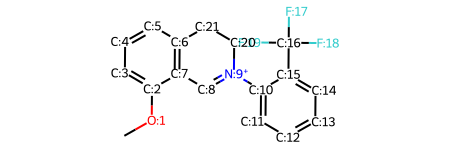

In [74]:
def mol_with_atom_index(mol):
    for atom in mol.GetAtoms():
        atom.SetAtomMapNum(atom.GetIdx())
    return mol


most_active_mol = df_clean_smiles['standard_value'].idxmax()
mol_NotCleaned = Chem.MolFromSmiles(df_combined['canonical_smiles'][DataPoint[most_active_mol]])
mol_with_atom_index(mol_NotCleaned)
mol_Cleaned = Chem.MolFromSmiles(df_combined_cleanSmiles['canonical_smiles'][DataPoint[most_active_mol]])
mol_with_atom_index(mol_Cleaned)

**function norm_value**: Values greater than $10^8$ will be fixed at $10^8$ otherwise the negative logarithmic value will become negative.

**function pIC50**: Now we need to convert the IC50 value to pIC50 because IC50 values are rather too large. Therefore,we want to look at their logarithm to make the work easier.

In [18]:
def norm_value(input):
    norm = []

    for i in input['standard_value']:
        if i > 1e8:
          i = 1e8
        norm.append(i)

    input['standard_value_norm'] = norm
    x = input.drop('standard_value', 1)
    return x

def pIC50(input):
    pIC50 = []

    for i in input['standard_value_norm']:
        molar = i*(10e-9) # Converts nM to M
        pIC50.append(-np.log10(molar))

    input['pIC50'] = pIC50
    x = input.drop('standard_value_norm', 1)

    return x

In [19]:
df_norm = norm_value(df_combined)
df_norm.standard_value_norm.describe()

<ipython-input-18-00f1948dafc3>:10: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x = input.drop('standard_value', 1)


count    6.156000e+03
mean     1.064838e+05
std      9.218820e+05
min      5.000000e-06
25%      1.480000e+02
50%      2.300000e+03
75%      1.700000e+04
max      4.960000e+07
Name: standard_value_norm, dtype: float64

In [20]:
df_combined[df_combined['molecule_chembl_id']=='CHEMBL4780352'] # this one was removed bc its IC50 value was wrong which was "0"

,molecule_chembl_id,canonical_smiles,standard_value,type,activity_class,MW,LogP,NumHDonors,NumHAcceptors,standard_value_norm


###Here is the curated, cleaned, and standardized data

In [21]:
df_final = pIC50(df_norm)
dir = '/content/gdrive/MyDrive/Colab Notebooks/Tutorial/Bioinformatics/data/'
df_final.to_csv(dir + 'acetylcholinesterase_04_bioactivity_data_3class_pIC50.csv')
df_2class = df_final[df_final['activity_class'] != 'intermediate']
df_2class.to_csv(dir + 'acetylcholinesterase_05_bioactivity_data_2class_pIC50.csv')
df_final.head(n=3)

<ipython-input-18-00f1948dafc3>:21: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x = input.drop('standard_value_norm', 1)


,molecule_chembl_id,canonical_smiles,type,activity_class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,IC50,active,312.325,2.8032,0.0,6.0,5.124939
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,IC50,active,376.913,4.5546,0.0,5.0,6.000000
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,IC50,inactive,426.851,5.3574,0.0,5.0,3.301030


#I have cleaned the code upto here

##Importing the the cleaned curated and standardized data
importing the above files (codes before this do not to be run since we are importing the files)

In [22]:
dir = '/content/gdrive/MyDrive/Colab Notebooks/Tutorial/Bioinformatics/data/'
df_final = pd.read_csv(dir + 'acetylcholinesterase_04_bioactivity_data_3class_pIC50.csv')
df_2class = pd.read_csv(dir + 'acetylcholinesterase_05_bioactivity_data_2class_pIC50.csv')

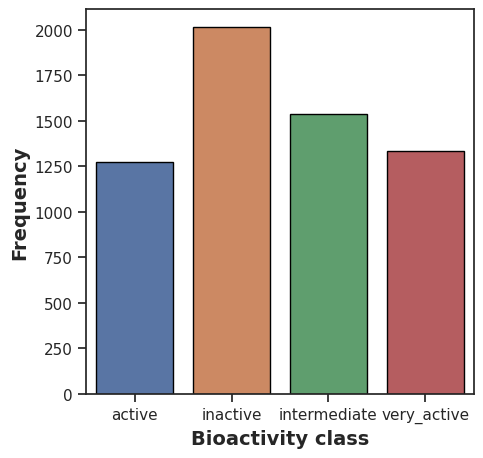

In [23]:
plt.figure(figsize=(5, 5))
sns.countplot(x='activity_class', data=df_final, edgecolor='black')
plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')
plt.savefig('plot_bioactivity_class.pdf')

It can be seen that the 2 bioactivity classes are spanning similar chemical spaces as evident by the scatter plot of MW vs LogP.

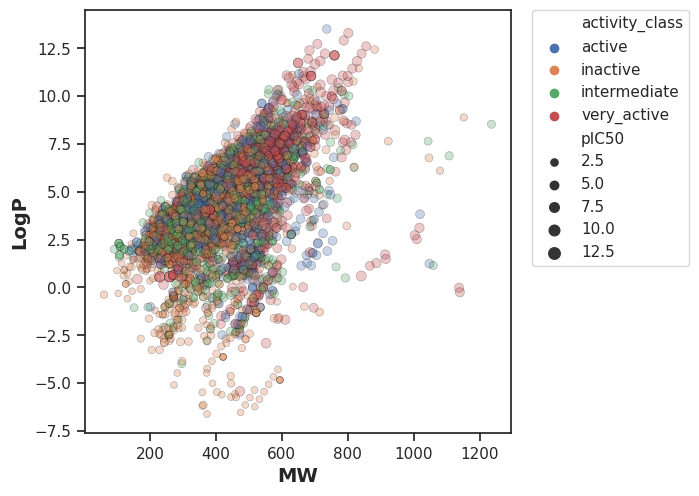

In [24]:
plt.figure(figsize=(5.5, 5.5))

sns.scatterplot(x='MW', y='LogP', data=df_final.head(5463), hue='activity_class', size='pIC50', edgecolor='black', alpha=0.3)

plt.xlabel('MW', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
#plt.savefig('plot_MW_vs_LogP.pdf')

To visually inspect whether there is correlation between diffrent Lipinski discriptors or there is a observable pattern in terms of the class activity

<Figure size 550x550 with 0 Axes>

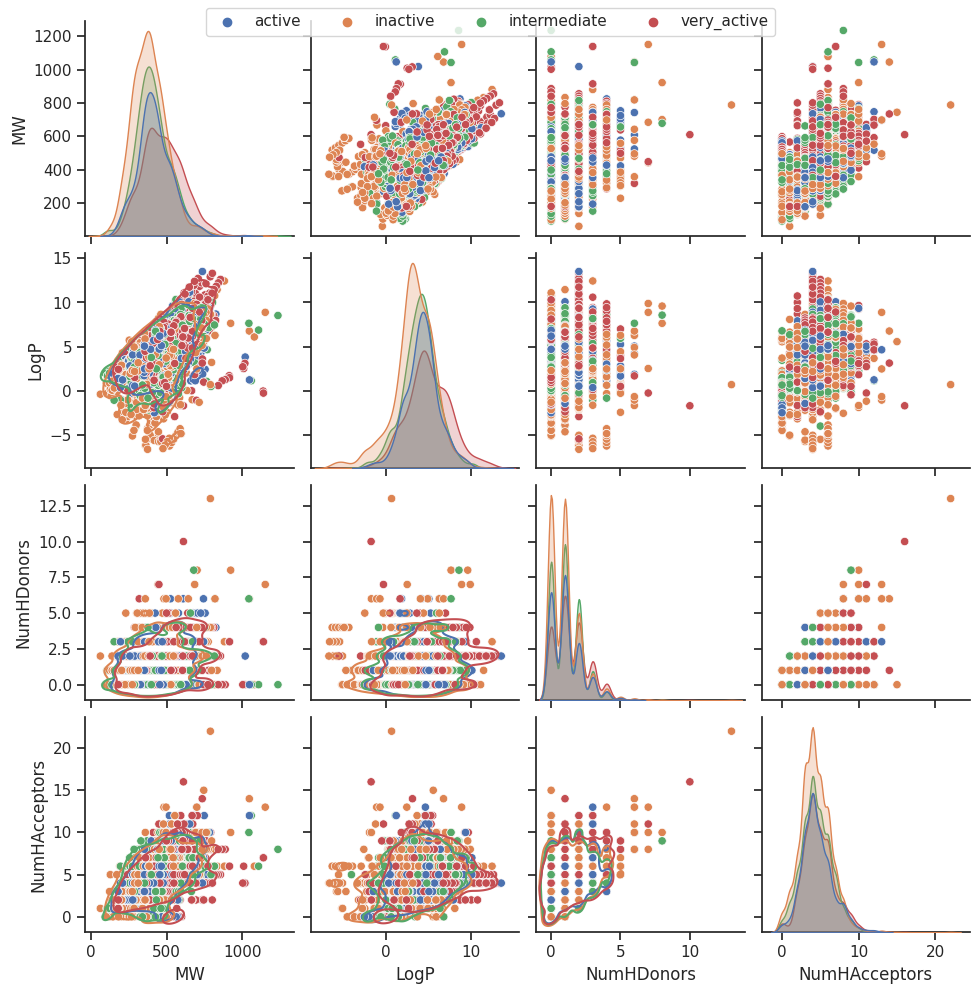

In [25]:
import seaborn
plt.figure(figsize=(5.5, 5.5))
cols_to_plot = df_final.columns[5:-1].tolist() + ['activity_class'] # explicitly add the column "Outcome" to your list of columns to plot
g = seaborn.pairplot( data=df_final[cols_to_plot], hue='activity_class')
g.map_lower(sns.kdeplot, levels=2, color="0.2")
g._legend.remove()

handles = g._legend_data.values()
labels = g._legend_data.keys()
g.fig.legend(handles=handles, labels=labels, loc='upper center', ncol=4)

**Statistical analysis | Mann-Whitney U Test**

In [26]:
def mannwhitney(descriptor, verbose=False):
  from numpy.random import seed
  from numpy.random import randn
  from scipy.stats import mannwhitneyu

# seed the random number generator
  seed(1)

# actives and inactives
  selection = [descriptor, 'activity_class']
  df = df_final[selection]
  active = df[df['activity_class'] == 'very_active']
  active = active[descriptor]

  selection = [descriptor, 'activity_class']
  df = df_final[selection]
  inactive = df[df['activity_class'] == 'inactive']
  inactive = inactive[descriptor]

# compare samples
  stat, p = mannwhitneyu(active, inactive)
  #print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
  alpha = 0.05
  if p > alpha:
    interpretation = 'Same distribution (fail to reject H0)'
  else:
    interpretation = 'Different distribution (reject H0)'

  results = pd.DataFrame({'Descriptor':descriptor,
                          'Statistics':stat,
                          'p':p,
                          'alpha':alpha,
                          'Interpretation':interpretation}, index=[0])
  filename = 'mannwhitneyu_' + descriptor + '.csv'
  results.to_csv(filename)

  return results

,Descriptor,Statistics,p,alpha,Interpretation
0,pIC50,2679984.0,0.0,0.05,Different distribution (reject H0)


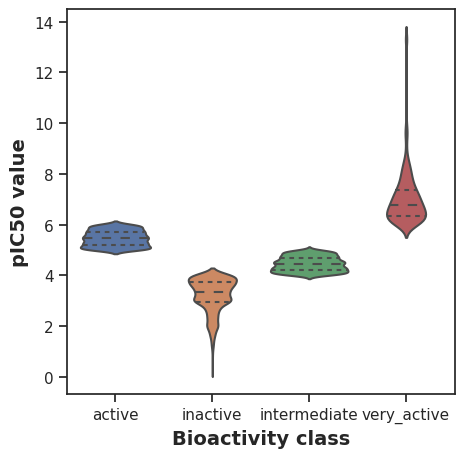

In [27]:
plt.figure(figsize=(5, 5))

sns.violinplot(x = 'activity_class', y = 'pIC50', data = df_final, inner='quartile')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('pIC50 value', fontsize=14, fontweight='bold')

plt.savefig('plot_ic50.pdf')
mannwhitney('pIC50')

#### **MW**

,Descriptor,Statistics,p,alpha,Interpretation
0,MW,1861075.0,4.948632e-81,0.05,Different distribution (reject H0)


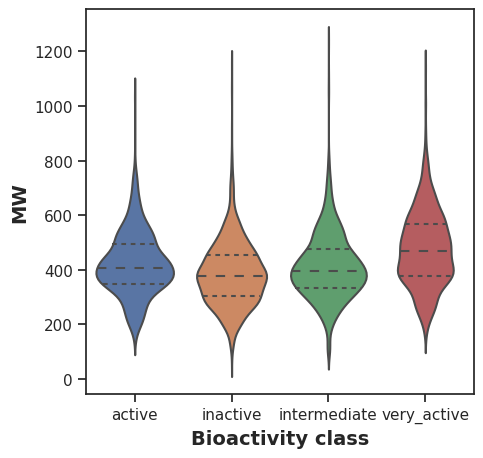

In [28]:
plt.figure(figsize=(5, 5))

sns.violinplot(x = 'activity_class', y = 'MW', data = df_final, inner='quartile')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('MW', fontsize=14, fontweight='bold')

plt.savefig('plot_MW.pdf')
mannwhitney('MW')

####**LogP**

,Descriptor,Statistics,p,alpha,Interpretation
0,LogP,1815898.0,6.697315e-68,0.05,Different distribution (reject H0)


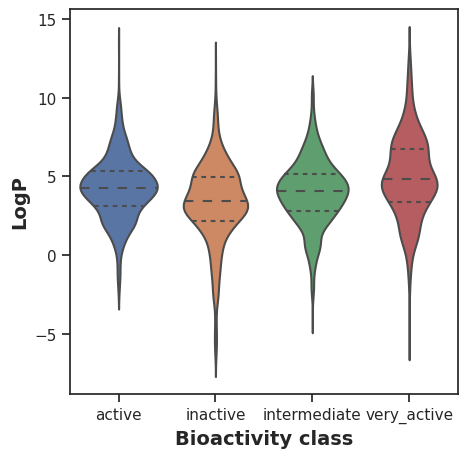

In [29]:
plt.figure(figsize=(5, 5))

sns.violinplot(x = 'activity_class', y = 'LogP', data = df_final, inner='quartile')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')

plt.savefig('plot_LogP.pdf')
mannwhitney('LogP')

#### **NumHDonors**

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHDonors,1650181.5,1.528894e-32,0.05,Different distribution (reject H0)


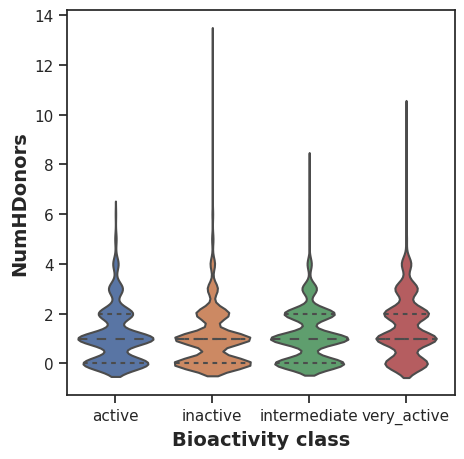

In [30]:
plt.figure(figsize=(5, 5))

sns.violinplot(x = 'activity_class', y = 'NumHDonors', data = df_final, inner='quartile')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHDonors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHDonors.pdf')
mannwhitney('NumHDonors')

#### **NumHAcceptors**

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHAcceptors,1487191.0,4.707202e-08,0.05,Different distribution (reject H0)


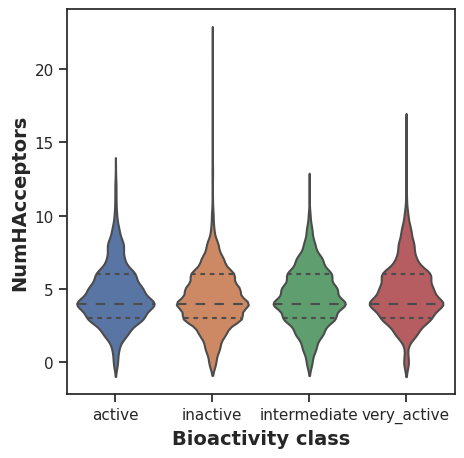

In [31]:
plt.figure(figsize=(5, 5))

sns.violinplot(x = 'activity_class', y = 'NumHAcceptors', data = df_final, inner='quartile')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHAcceptors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHAcceptors.pdf')
mannwhitney('NumHAcceptors')

##### **Box Plots**

###### **pIC50 values**

Taking a look at pIC50 values, the **actives** and **inactives** displayed ***statistically significant difference***, which is to be expected since threshold values (``IC50 < 1,000 nM = Actives while IC50 > 10,000 nM = Inactives``, corresponding to ``pIC50 > 6 = Actives and pIC50 < 5 = Inactives``) were used to define actives and inactives.

###### **Lipinski's descriptors**

All of the 4 Lipinski's descriptors exhibited ***statistically significant difference*** between the **very actives** and **inactives**.

# **Bioinformatics Project - Computational Drug Discovery [Part 3] Descriptor Calculation and Dataset Preparation**

Chanin Nantasenamat

[*'Data Professor' YouTube channel*](http://youtube.com/dataprofessor)

In this Jupyter notebook, we will be building a real-life **data science project** that you can include in your **data science portfolio**. Particularly, we will be building a machine learning model using the ChEMBL bioactivity data.

In **Part 3**, we will be calculating molecular descriptors that are essentially quantitative description of the compounds in the dataset. Finally, we will be preparing this into a dataset for subsequent model building in Part 4.

---

## **Download PaDEL-Descriptor**

In [ ]:
! wget https://github.com/dataprofessor/bioinformatics/raw/master/padel.zip
! wget https://github.com/dataprofessor/bioinformatics/raw/master/padel.sh

In [ ]:
! unzip padel.zip

In [ ]:
# data from data professor github same as the file we imported above in the importing section 2 data
! wget https://raw.githubusercontent.com/dataprofessor/data/master/acetylcholinesterase_04_bioactivity_data_3class_pIC50.csv

In [51]:
dir = '/content/gdrive/MyDrive/Colab Notebooks/Tutorial/Bioinformatics/data/'
#df2 = pd.read_csv('acetylcholinesterase_04_bioactivity_data_3class_pIC50.csv') # data from the github of dataprofessor
df3 = pd.read_csv(dir + 'acetylcholinesterase_04_bioactivity_data_3class_pIC50.csv') # same file which is more uptodate and made by myself containing 4 classes
df3

,Unnamed: 0,molecule_chembl_id,canonical_smiles,type,activity_class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,IC50,active,312.325,2.8032,0.0,6.0,5.124939
1,1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,IC50,active,376.913,4.5546,0.0,5.0,6.000000
2,2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,IC50,inactive,426.851,5.3574,0.0,5.0,3.301030
3,3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,IC50,active,404.845,4.7069,0.0,5.0,5.522879
4,4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,IC50,active,346.334,3.0953,0.0,6.0,5.096910
...,...,...,...,...,...,...,...,...,...,...
6151,6151,CHEMBL5219841,COc1cccc2c1CCCC2NS(=O)(=O)NC(=O)OCc1ccccc1,IC50,very_active,390.461,2.8334,2.0,5.0,8.679854
6152,6152,CHEMBL5219046,CC[C@@]1(c2cccc(OC(=O)Nc3ccccc3)c2)CCCCN(C)C1,IC50,active,352.478,5.0610,1.0,3.0,5.562249
6153,6153,CHEMBL5219594,O=c1[nH]c2ccc(OCc3ccc(F)cc3)cc2c(=O)o1,IC50,inactive,287.246,2.1994,1.0,4.0,3.118045
6154,6154,CHEMBL5219958,CC(C)c1ccc(COc2ccc3[nH]c(=O)oc(=O)c3c2)cc1,IC50,inactive,311.337,3.1837,1.0,4.0,3.259637


In [69]:
selection = ['canonical_smiles', 'molecule_chembl_id']
df_selection = df3[selection]
df_selection.to_csv('molecule.smi', sep='\t', index=False, header=False)
! cat molecule.smi  | head -3

CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1	CHEMBL133897
O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1	CHEMBL336398
CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1	CHEMBL131588


In [ ]:
! bash padel.sh

In [60]:
df3_X = pd.read_csv('descriptors_output.csv')
df3_X.to_csv(dir + 'descriptors_output.csv')
df3_X

,Name,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,CHEMBL336398,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,CHEMBL133897,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,CHEMBL130628,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,CHEMBL131588,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,CHEMBL130478,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6151,CHEMBL5219841,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6152,CHEMBL5219594,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6153,CHEMBL5219046,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6154,CHEMBL5219958,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [62]:
df3_Y = df3['pIC50']
dataset3 = pd.concat([df3_X, df3_Y], axis=1)
dataset3.to_csv(dir+'acetylcholinesterase_06_bioactivity_data_4class_pIC50_pubchem_fp.csv', index=False)

# Run From Here
importing the above cell which we just saved so we do not have to do it everytime

In [63]:
dataset3 = pd.read_csv(dir+'acetylcholinesterase_06_bioactivity_data_4class_pIC50_pubchem_fp.csv')
dataset3.head(n=3)

,Name,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,...,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880,pIC50
0,CHEMBL336398,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5.124939
1,CHEMBL133897,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6.000000
2,CHEMBL130628,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3.301030


To remove low variace features

In [64]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from math import inf
selection = VarianceThreshold(threshold=(0.8*(1-0.8)))
# we need to drop the PIC50 column in order to only have the pubchem features

X0 = dataset3.drop('pIC50', axis=1)
y = dataset3['pIC50']
inf_indx = np.argmax(y==inf)
#droping the inf values
X0 = X0.drop(inf_indx)
y = y.drop(inf_indx)
X = X0.drop('Name', axis=1)
X = selection.fit_transform(X)
X.shape
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)
X_train.shape
y_test.shape

(1231,)

Building a Random Forst Model

In [65]:
np.random.seed(42)
model = RandomForestRegressor(n_estimators=100)
model.fit(X_train, y_train)
r2 = model.score(X_test, y_test)
y_pred = model.predict(X_test)

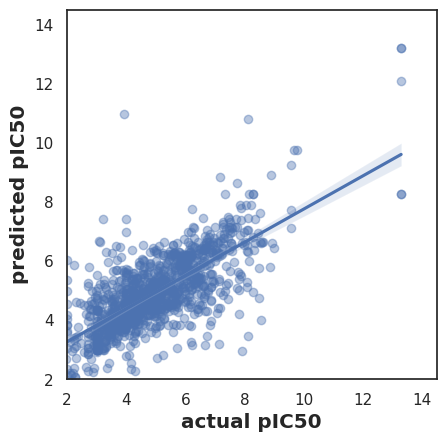

In [66]:
sns.set(color_codes=True)
sns.set_style('white')

ax = sns.regplot(x=y_test, y=y_pred, scatter_kws={'alpha':0.4})
ax.set_xlabel('actual pIC50', fontsize='large', fontweight='bold')
ax.set_ylabel('predicted pIC50', fontsize='large', fontweight='bold')
ax.set_xlim([2,14.5])
ax.set_ylim([2,14.5])
ax.set_aspect('equal')


Part 5. Building several ML models

In [ ]:
from lazypredict.Supervised import LazyRegressor, REGRESSORS
REGRESSORS.remove(REGRESSORS[31])
all_models = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
train, test = all_models.fit(X_train, X_test, y_train, y_test)

HG-Bossting regressor has the higher adjusted R-Squared with a relatively short fitting time

In [75]:
test[:10]

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
HistGradientBoostingRegressor,0.48,0.54,1.11,1.83
RandomForestRegressor,0.46,0.53,1.12,7.99
LGBMRegressor,0.46,0.53,1.12,0.53
KNeighborsRegressor,0.44,0.51,1.15,0.25
BaggingRegressor,0.44,0.50,1.15,0.71
XGBRegressor,0.43,0.50,1.16,3.01
SVR,0.41,0.48,1.17,3.73
NuSVR,0.41,0.48,1.18,2.81
MLPRegressor,0.37,0.45,1.21,13.50
